In [1]:
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the epochs
epochs = mne.read_epochs("combined-epo.fif")

# Apply preprocessing filter
epochs.filter(6, 64, method='iir', iir_params=dict(order=5, ftype='butter'))


Reading C:\Users\dhanu\Desktop\Caps\code\combined-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1050 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 6.00, 64.00 Hz: -6.02, -6.02 dB



Number of events,1050
Events,Freq_10: 210Freq_11: 210Freq_12: 210Freq_8: 210Freq_9: 210
Time range,0.000 – 5.996 s
Baseline,0.000 – 0.000 s


In [3]:
def generate_reference_signals(frequencies, sfreq, n_samples):
    t = np.arange(n_samples) / sfreq
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(np.sin(2 * np.pi * freq * t))
        ref_signals.append(np.cos(2 * np.pi * freq * t))
    return np.array(ref_signals).T

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

C:\Users\dhanu\AppData\Local\Temp\ipykernel_2508\3261200443.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  original_signal = epochs.get_data()[0]  # Get data from the first epoch for visualization


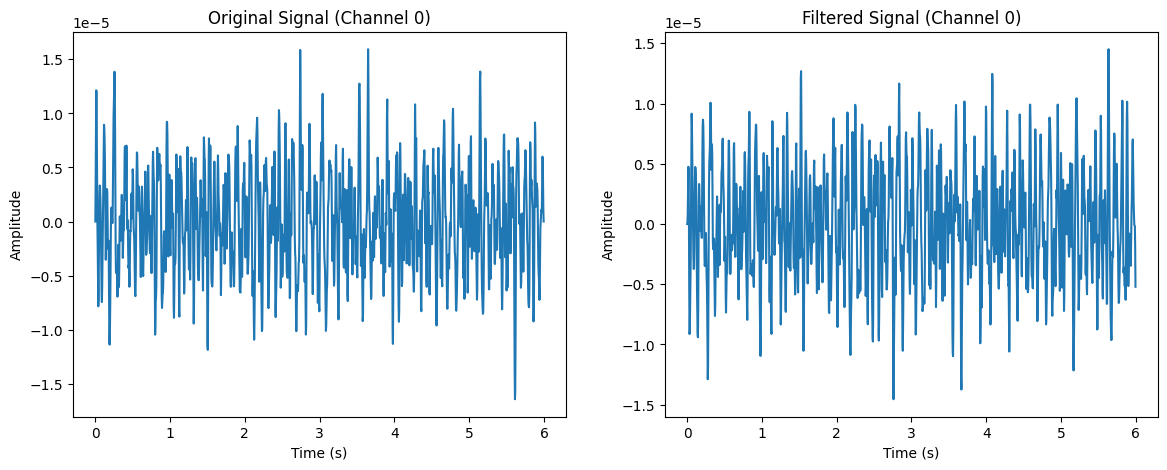

In [4]:
# Define the sampling frequency (sfreq)
sfreq = 250  # This should match the actual sampling frequency of your data

# Visualize Original vs. Filtered Signal
def plot_signals(original_signal, filtered_signal, sfreq, ch_idx=0):
    time = np.arange(original_signal.shape[1]) / sfreq
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(time, original_signal[ch_idx, :])
    plt.title(f'Original Signal (Channel {ch_idx})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    plt.plot(time, filtered_signal[ch_idx, :])
    plt.title(f'Filtered Signal (Channel {ch_idx})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.show()

# Apply filtering and visualize the result
original_signal = epochs.get_data()[0]  # Get data from the first epoch for visualization
filtered_signal = bandpass_filter(original_signal, 6, 64, sfreq)

plot_signals(original_signal, filtered_signal, sfreq)


In [5]:
# Define ICA parameters and fit ICA
n_components = 3
method = 'fastica'
ica = ICA(n_components=n_components, method=method, random_state=97)
ica.fit(epochs)
ica.apply(epochs)

Fitting ICA to data using 3 channels (please be patient, this may take a while)


C:\Users\dhanu\AppData\Local\Temp\ipykernel_2508\1557627185.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 3 components
Fitting ICA took 2.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 3 PCA components


C:\Users\dhanu\AppData\Local\Temp\ipykernel_2508\1557627185.py:6: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


Number of events,1050
Events,Freq_10: 210Freq_11: 210Freq_12: 210Freq_8: 210Freq_9: 210
Time range,0.000 – 5.996 s
Baseline,0.000 – 0.000 s


C:\Users\dhanu\AppData\Local\Temp\ipykernel_2508\2596998508.py:22: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ica_signal = epochs.get_data()[0]  # Get ICA-processed data from the first epoch


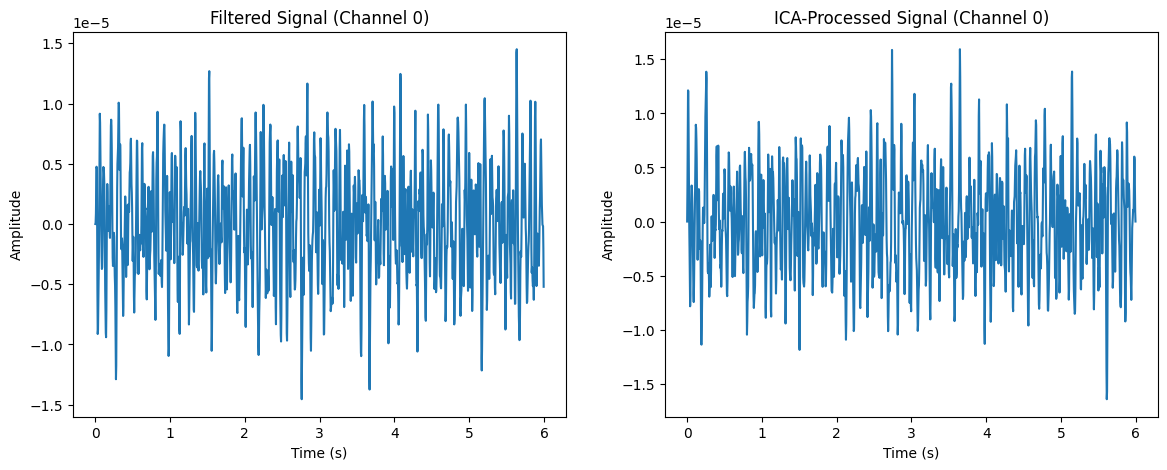

In [6]:
# Visualize Filtered vs. ICA-Processed Signal
def plot_ica_signals(filtered_signal, ica_signal, sfreq, ch_idx=0):
    time = np.arange(filtered_signal.shape[1]) / sfreq
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(time, filtered_signal[ch_idx, :])
    plt.title(f'Filtered Signal (Channel {ch_idx})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    plt.plot(time, ica_signal[ch_idx, :])
    plt.title(f'ICA-Processed Signal (Channel {ch_idx})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.show()

# Apply ICA and visualize the result
ica_signal = epochs.get_data()[0]  # Get ICA-processed data from the first epoch
plot_ica_signals(filtered_signal, ica_signal, sfreq)

In [7]:

# Normalize the data
epochs_data = epochs.get_data(copy=False)
epochs_data = (epochs_data - np.mean(epochs_data, axis=-1, keepdims=True)) / np.std(epochs_data, axis=-1, keepdims=True)


In [8]:

def fbcca_features(epochs, frequencies, sfreq, n_samples, filter_bank):
    cca = CCA(n_components=1)
    n_epochs = epochs.shape[0]
    n_channels = epochs.shape[1]
    
    fbcca_features = []

    for epoch_idx in range(n_epochs):
        epoch_data = epochs[epoch_idx]

        corr_features = []

        for freq in frequencies:
            for fb in filter_bank:
                filtered_data = np.zeros((n_channels, n_samples))
                
                for ch in range(n_channels):
                    filtered_data[ch, :] = bandpass_filter(epoch_data[ch, :], fb['low'], fb['high'], sfreq)
                
                filtered_data = filtered_data.T
                ref_signals = generate_reference_signals([freq], sfreq, n_samples)
                
                X_c, Y_c = cca.fit_transform(filtered_data, ref_signals)
                
                corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
                corr_features.append(corr)
        
        fbcca_features.append(corr_features)

    return np.array(fbcca_features)

In [9]:

frequencies = [8, 9, 10, 11, 12]  # Example stimulus frequencies in Hz
sfreq = 250
n_samples_per_epoch = 1500
# Create the filter bank
filter_bank = [
    {'low': 6, 'high': 18},
    {'low': 14, 'high': 36},
    {'low': 28, 'high': 64}
]

# Generate FBCCA features
fbcca_features_data = fbcca_features(epochs_data, frequencies, sfreq, n_samples_per_epoch, filter_bank)

# Check the shape of the FBCCA features
print("FBCCA features shape:", fbcca_features_data.shape)

FBCCA features shape: (1050, 15)


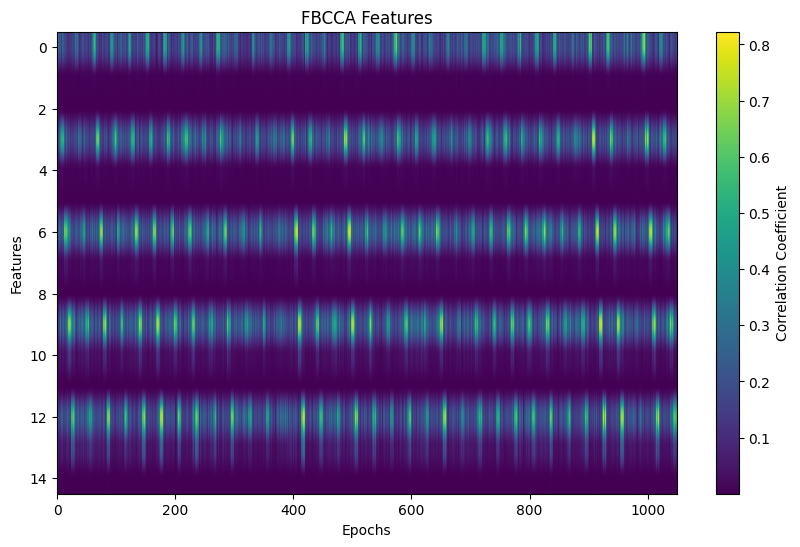

In [10]:
# Visualize FBCCA Features
def plot_fbcca_features(fbcca_features_data):
    plt.figure(figsize=(10, 6))
    plt.imshow(fbcca_features_data.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Correlation Coefficient')
    plt.title('FBCCA Features')
    plt.xlabel('Epochs')
    plt.ylabel('Features')
    plt.show()

# Plot FBCCA features
plot_fbcca_features(fbcca_features_data)

In [11]:
# # Show input classes vs. predicted classes after classification
# def plot_class_predictions(true_labels, predicted_labels):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix - CNN with FBCCA Features (Test Set)')
#     plt.show()

# # Plot input vs predicted classes
# plot_class_predictions(true_labels, predicted_labels)

In [12]:

# Adjust num_classes to the highest label value + 1
labels = epochs.events[:, -1] + 7
num_classes = np.max(labels) + 1
labels_categorical = to_categorical(labels, num_classes=num_classes)

# Reshape the features for CNN input
n_epochs, n_features = fbcca_features_data.shape
fbcca_features_reshaped = fbcca_features_data.reshape(n_epochs, n_features, 1, 1)
input_shape = (n_features, 1, 1)

# Split the data into training and testing sets
fbcca_train, fbcca_test, labels_train, labels_test = train_test_split(
    fbcca_features_reshaped, labels_categorical, test_size=0.2, random_state=42)

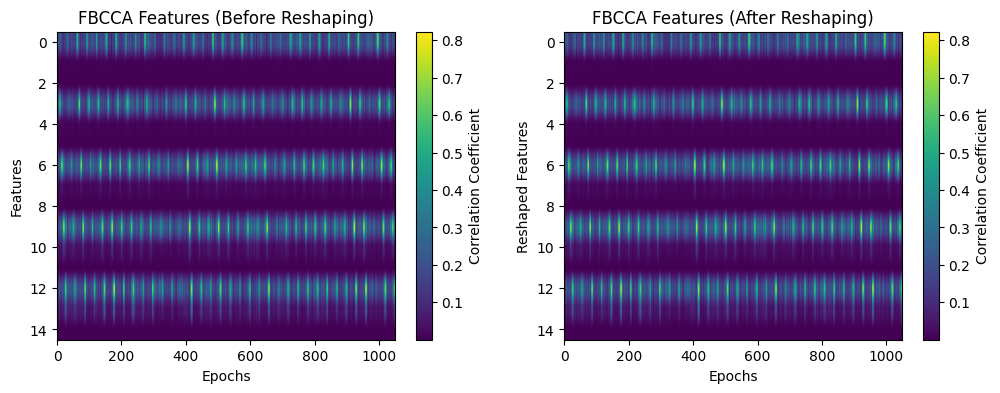


Shape Before Reshaping: (1050, 15)
Shape After Reshaping: (1050, 15, 1, 1)


In [13]:
# Visualize Data Reshaping for CNN
def plot_data_reshaping(fbcca_features_data, fbcca_features_reshaped):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(fbcca_features_data.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Correlation Coefficient')
    plt.title('FBCCA Features (Before Reshaping)')
    plt.xlabel('Epochs')
    plt.ylabel('Features')
    
    plt.subplot(1, 2, 2)
    reshaped = fbcca_features_reshaped.reshape(fbcca_features_data.shape[0], -1)
    plt.imshow(reshaped.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Correlation Coefficient')
    plt.title('FBCCA Features (After Reshaping)')
    plt.xlabel('Epochs')
    plt.ylabel('Reshaped Features')
    
    plt.show()

# Plot reshaped data for CNN
plot_data_reshaping(fbcca_features_data, fbcca_features_reshaped)

# Confirm the shape before and after reshaping
print("\nShape Before Reshaping:", fbcca_features_data.shape)
print("Shape After Reshaping:", fbcca_features_reshaped.shape)


In [14]:

# Define the CNN model for FBCCA features
model = Sequential([
    Conv2D(32, kernel_size=(n_features, 1), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model with FBCCA features
history = model.fit(fbcca_train, labels_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the CNN model on the test set
cnn_accuracy = model.evaluate(fbcca_test, labels_test)[1]
print(f"The accuracy of the CNN with FBCCA features on the test EEG data is {cnn_accuracy}")


C:\Users\dhanu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1055 - loss: 3.8075 - val_accuracy: 0.3393 - val_loss: 2.5562
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1213 - loss: 3.2944 - val_accuracy: 0.2202 - val_loss: 2.5464
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1583 - loss: 2.9823 - val_accuracy: 0.2143 - val_loss: 2.5327
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2332 - loss: 2.5681 - val_accuracy: 0.2143 - val_loss: 2.5152
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3070 - loss: 2.2193 - val_accuracy: 0.2143 - val_loss: 2.4939
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3184 - loss: 2.1782 - val_accuracy: 0.2143 - val_loss: 2.4683
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4581 - loss: 1.7604 - val_accuracy: 0.2143 - val_loss: 2.4368
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4688 - loss: 1.7470 - val_accuracy: 0.2143 - 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


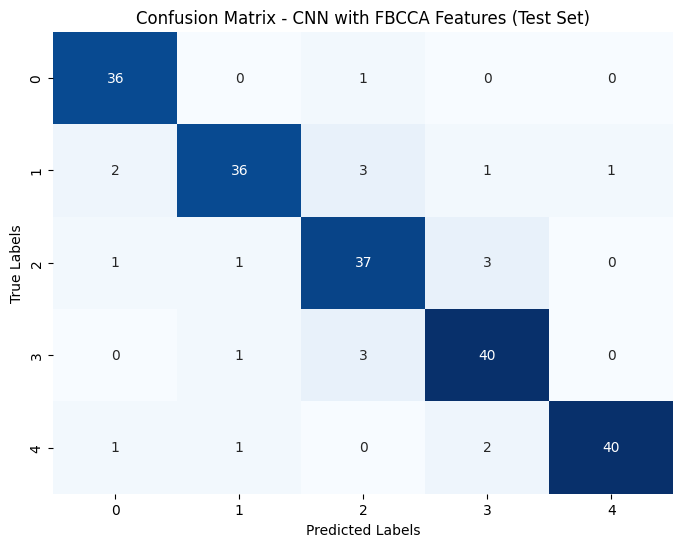

In [15]:
# Predictions
predictions = model.predict(fbcca_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)

# Confusion matrix for CNN on test set
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN with FBCCA Features (Test Set)')
plt.show()

In [16]:
# Select a few test samples (e.g., first 5 epochs from the test set)
selected_epochs = fbcca_test[:5]
selected_true_labels = np.argmax(labels_test[:5], axis=1)  # Convert one-hot labels to integer labels

# Predict the classes using the CNN model
selected_predictions = model.predict(selected_epochs)
selected_predicted_labels = np.argmax(selected_predictions, axis=1)

# Display true vs predicted classes
print("True vs Predicted Classes for Selected Epochs:")
for i in range(len(selected_true_labels)):
    print(f"Epoch {i+1}: True Class = {selected_true_labels[i]}, Predicted Class = {selected_predicted_labels[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True vs Predicted Classes for Selected Epochs:
Epoch 1: True Class = 11, Predicted Class = 9
Epoch 2: True Class = 12, Predicted Class = 11
Epoch 3: True Class = 8, Predicted Class = 8
Epoch 4: True Class = 12, Predicted Class = 8
Epoch 5: True Class = 8, Predicted Class = 8


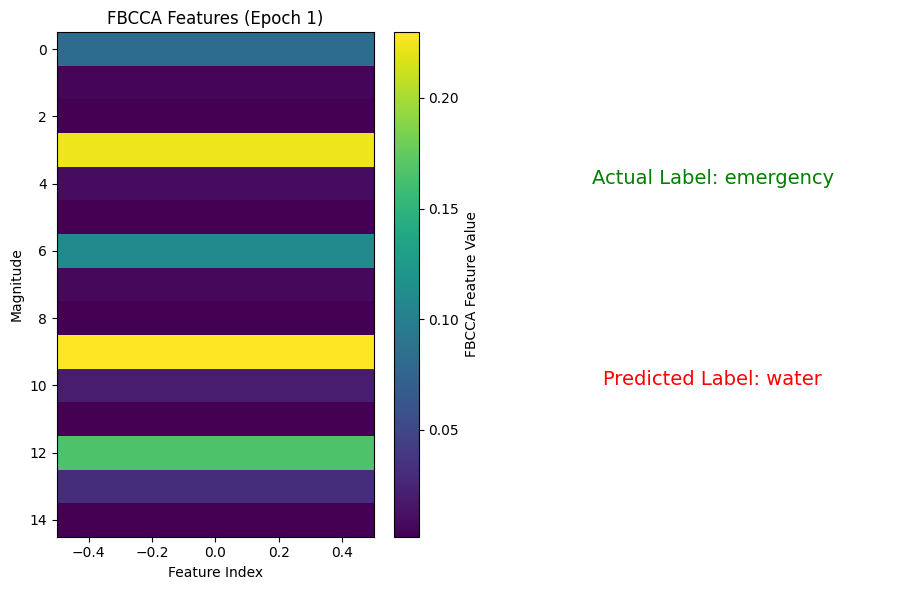

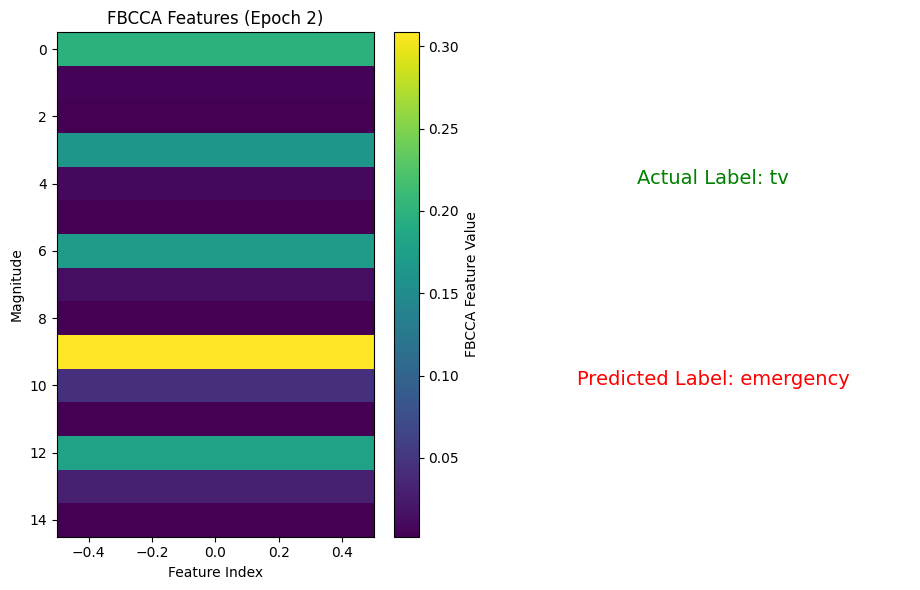

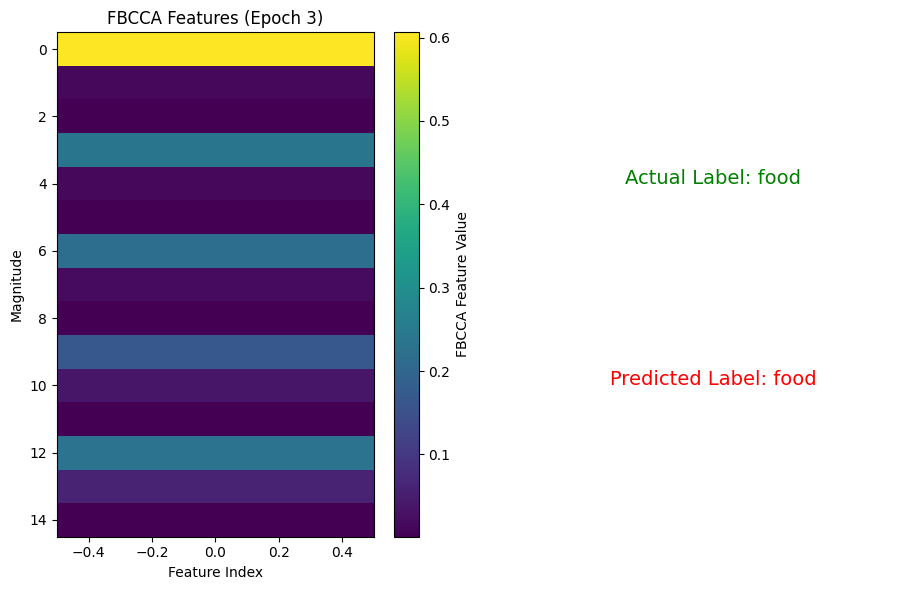

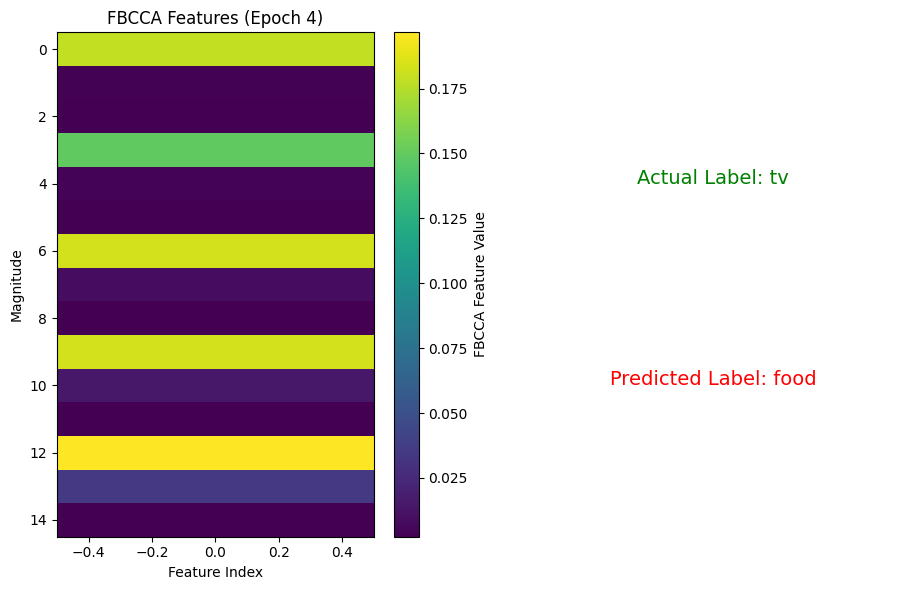

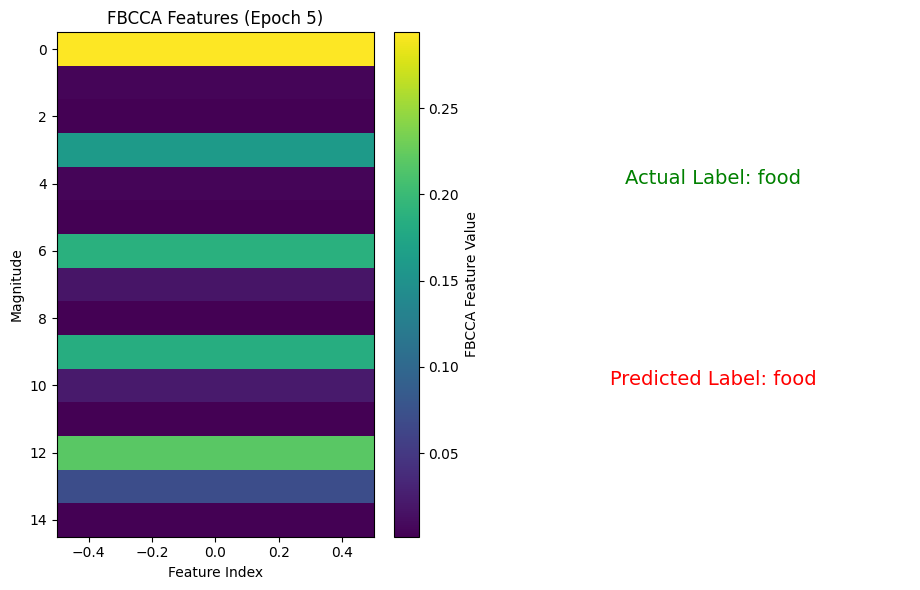

In [18]:
# Define label mapping
label_mapping = {
    8: "food",
    9: "water",
    10: "washroom",
    11: "emergency",
    12: "tv"
}

def visualize_classified_epochs_with_labels(selected_epochs, selected_fbcca_features, selected_true_labels, selected_predicted_labels, sfreq, ch_idx=0):
    time = np.arange(selected_epochs.shape[2]) / sfreq
    num_epochs = selected_epochs.shape[0]
    
    for i in range(num_epochs):
        plt.figure(figsize=(18, 6))
        
        # Original Signal (optional, uncomment if needed)
        # plt.subplot(1, 4, 1)
        # plt.plot(time, selected_epochs[i, ch_idx, :])
        # plt.title(f'Original Signal (Epoch {i+1}, Channel {ch_idx})')
        # plt.xlabel('Time (s)')
        # plt.ylabel('Amplitude')

        # FBCCA Features (as a heatmap)
        plt.subplot(1, 4, 2)
        plt.imshow(selected_fbcca_features[i].reshape(-1, 1), aspect='auto', cmap='viridis')
        plt.colorbar(label='FBCCA Feature Value')
        plt.title(f'FBCCA Features (Epoch {i+1})')
        plt.xlabel('Feature Index')
        plt.ylabel('Magnitude')

        # Actual and Predicted Labels
        true_label = label_mapping.get(selected_true_labels[i], "Unknown")
        predicted_label = label_mapping.get(selected_predicted_labels[i], "Unknown")
        
        plt.subplot(1, 4, 3)
        plt.text(0.5, 0.7, f'Actual Label: {true_label}', fontsize=14, ha='center', color='green')
        plt.text(0.5, 0.3, f'Predicted Label: {predicted_label}', fontsize=14, ha='center', color='red')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Use fbcca_test as selected_fbcca_features
visualize_classified_epochs_with_labels(selected_epochs, fbcca_test, selected_true_labels, selected_predicted_labels, sfreq)
